In [3]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score , ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from sklearn import metrics

%matplotlib inline

# Load the Data

In [6]:
df = pd.read_csv(r"C:\Users\almal\Desktop\cleaned_dataset_A.csv") # Using the cleaned dataset from the EDA stage, retaining the position columns.

# Preprocess the Data

In [9]:
# Drop the 'position_encoded' column because there is another column with the same meaning
df.drop(['position_encoded'], axis=1, inplace=True)

# Keeping the original 'position' column intact for further encoding steps

In [11]:
df

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,winger
0,Manchester United,Defender Centre-Back,186.000000,21.0,34,0.000000,0.000000,0.130529,0.0,0.000000,0.000000,0.000000,2758,47,13,0,2000000,2000000,0
1,Manchester United,midfield-CentralMidfield,181.000000,20.0,39,0.129125,0.064562,0.225968,0.0,0.000000,0.000000,0.000000,2788,0,0,1,800000,800000,0
2,Manchester United,midfield-CentralMidfield,175.000000,18.0,51,0.153759,0.102506,0.000000,0.0,0.000000,0.000000,0.000000,3512,0,0,1,800000,800000,0
3,Leicester City,Goalkeeper,191.000000,25.0,65,0.000000,0.000000,0.015340,0.0,0.000000,1.257883,0.291461,5867,0,0,0,2000000,2000000,0
4,Leicester City,Goalkeeper,189.000000,33.0,31,0.000000,0.000000,0.064516,0.0,0.000000,1.483871,0.161290,2790,89,14,0,600000,3500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,Western Sydney Wanderers,Attack-RightWinger,181.240353,20.0,16,0.175953,0.087977,0.263930,0.0,0.000000,0.000000,0.000000,1023,0,0,0,75000,75000,1
5731,Western Sydney Wanderers,Attack Centre-Forward,190.000000,24.0,26,0.372671,0.186335,0.186335,0.0,0.000000,0.000000,0.000000,1449,102,18,0,300000,300000,0
5732,Western Sydney Wanderers,Attack Centre-Forward,181.240353,19.0,20,0.375000,0.000000,0.187500,0.0,0.000000,0.000000,0.000000,960,0,0,0,50000,50000,0
5733,Western Sydney Wanderers,Attack Centre-Forward,181.240353,20.0,17,0.312139,0.104046,0.000000,0.0,0.104046,0.000000,0.000000,865,0,0,0,50000,50000,0


In [13]:
# Split all features into categorical and numeric
categorical_features = ['team','position']
numeric_features = ['height' , 'age','appearance','goals','assists','yellow cards','second yellow cards','red cards','goals conceded','clean sheets','minutes played','days_injured','games_injured',
                    'award','current_value','highest_value','winger']

In [15]:
# one hot encoding for categorical_features
df = pd.get_dummies(df, columns = categorical_features, drop_first=True)

In [17]:
df.shape

(5735, 387)

In [19]:
# Define a threshold for binary classification by using the median
threshold = df['current_value'].median()

# Function to categorize into binary classes: Low or High
def categorize_values_binary(value):
    if value <= threshold:
        return 'Low'
    else:
        return 'High'

# Apply the function to create a new binary classification column
df['current_value_category'] = df['current_value'].apply(categorize_values_binary)

# Drop the original 'current_value' column as it's no longer needed
df.drop('current_value', axis=1, inplace=True)

# Check the distribution of the new binary categories
print(df['current_value_category'].value_counts())


current_value_category
Low     3112
High    2623
Name: count, dtype: int64


In [21]:
df[['current_value_category']]

,current_value_category
0,High
1,High
2,High
3,High
4,High
...,...
5730,Low
5731,Low
5732,Low
5733,Low


In [23]:
encoder = LabelEncoder()
df['current_value_category_encoded'] = encoder.fit_transform(df['current_value_category']) 

# Feature selection

In [26]:
correlation = df.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
position_Goalkeeper               0.165113
goals conceded                    0.115830
position_midfield                 0.091985
team_Richards Bay FC              0.062908
                                    ...   
games_injured                    -0.189400
assists                          -0.240275
minutes played                   -0.383475
appearance                       -0.390704
highest_value                    -0.628608
Name: current_value_category_encoded, Length: 387, dtype: float64


In [28]:
threshold = 0.10 

selected_features = correlation[abs(correlation['current_value_category_encoded']) > threshold]['current_value_category_encoded'].index
selected_features

Index(['appearance', 'goals', 'assists', 'goals conceded', 'minutes played',
       'days_injured', 'games_injured', 'award', 'highest_value',
       'position_Goalkeeper', 'current_value_category_encoded'],
      dtype='object')

In [30]:
df.drop('current_value_category', axis=1, inplace=True)

In [32]:
selected_features = ['appearance', 'goals', 'assists', 'goals conceded', 'minutes played',
       'days_injured', 'games_injured', 'award', 'highest_value',
       'position_Goalkeeper', 'current_value_category_encoded']

In [34]:
df = df[selected_features]
df.head()

,appearance,goals,assists,goals conceded,minutes played,days_injured,games_injured,award,highest_value,position_Goalkeeper,current_value_category_encoded
0,34,0.000000,0.000000,0.000000,2758,47,13,0,2000000,False,0
1,39,0.129125,0.064562,0.000000,2788,0,0,1,800000,False,0
2,51,0.153759,0.102506,0.000000,3512,0,0,1,800000,False,0
3,65,0.000000,0.000000,1.257883,5867,0,0,0,2000000,True,0
4,31,0.000000,0.000000,1.483871,2790,89,14,0,3500000,True,0


In [36]:
# Prepare data
X = df.drop(['current_value_category_encoded'], axis=1)
y = df['current_value_category_encoded']


# Split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
X.shape

(5735, 10)

# Build both Models (DT and RF)

In [41]:
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()

In [43]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 15,17],   # Regularization strength
    'n_estimators':[35, 40, 50, 60, 70, 80, 90]
}
grid_search = GridSearchCV(estimator=rf_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

# Train both Models (DT and RF)

In [46]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [48]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [50]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 10, 15, 17],
                         'n_estimators': [35, 40, 50, 60, 70, 80, 90]},
             scoring='f1_macro', verbose=1)

In [52]:
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 35}

In [54]:
best_model = grid_search.best_estimator_

# Test both Models (DT and RF)

In [57]:
y_pred_dt = dt_classifier.predict(X_test)
y_pred_rf = rf_classifier.predict(X_test)
y_pred_rf_g = best_model.predict(X_test)

# Evaluating Decision Tree model

In [60]:
# our benchmark model
base_model = round(df['current_value_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

54.26

In [62]:
accuracy = accuracy_score(y_test, y_pred_dt)
accuracy
# The Decision Tree achieved an accuracy of 0.83 on the test set.

0.8369659982563208

In [114]:
y_pred_train_dt = dt_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_dt)
accuracy
# There is overfitting in Decision Tree

0.9997820401046208

In [66]:
# Calculate Precision
precision = precision_score(y_test, y_pred_dt, average='macro')
precision

0.8357011183482856

In [68]:
# Calculate Recall
recall = recall_score(y_test, y_pred_dt, average='macro')
recall

0.8351245245982089

In [70]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred_dt, average='macro')
f1

0.8353965458361632

In [72]:
# Confusion matrix for Random Forest best model
conf_matrix = confusion_matrix(y_test, y_pred_dt)
conf_matrix

array([[424,  96],
       [ 91, 536]], dtype=int64)

In [74]:
# Evaluating results for the Random Forest best model
print(classification_report(y_test,
                      y_pred_dt,
                      labels=list(best_model.classes_)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       520
           1       0.85      0.85      0.85       627

    accuracy                           0.84      1147
   macro avg       0.84      0.84      0.84      1147
weighted avg       0.84      0.84      0.84      1147



# Evaluating Random Forest model

In [77]:
accuracy = accuracy_score(y_test, y_pred_rf)
accuracy
# The Random Forest achieved an accuracy of 0.84 on the test set, which is 5% higher than the Decision Tree.

0.8945074106364429

In [79]:
y_pred_train_rf = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf)
accuracy
# There is overfitting.

0.9997820401046208

In [116]:
# It seems like there is overfitting, as the model achieves 0.99 accuracy on the training set using Dt and RF while on testing achieved 0.83 and 0.89

In [83]:
# Calculate Precision
precision = precision_score(y_test, y_pred_rf, average='macro')
precision

0.8979596502780216

In [85]:
# Calculate Recall
recall = recall_score(y_test, y_pred_rf, average='macro')
recall

0.9003910563121089

In [87]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred_rf, average='macro')
f1

0.894461203635194

In [89]:
# Confusion matrix for Random Forest
conf_matrix = confusion_matrix(y_test, y_pred_rf)
conf_matrix

array([[501,  19],
       [102, 525]], dtype=int64)

In [91]:
# Evaluating results for the Random Forest best model
print(classification_report(y_test,
                      y_pred_rf,
                      labels=list(best_model.classes_)))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       520
           1       0.97      0.84      0.90       627

    accuracy                           0.89      1147
   macro avg       0.90      0.90      0.89      1147
weighted avg       0.90      0.89      0.89      1147



# Evaluating Random Forest best model

In [94]:
accuracy = accuracy_score(y_test, y_pred_rf_g)
accuracy

0.8971229293809939

In [96]:
y_pred_train_rf_g = best_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf_g)
accuracy

0.9195727986050567

In [98]:
# By using the best model for Random Forest, overfitting has been reduced, and the results appear to be ideal.


In [100]:
# Confusion matrix for Random Forest best model
conf_matrix = confusion_matrix(y_test, y_pred_rf_g)
conf_matrix

array([[512,   8],
       [110, 517]], dtype=int64)

In [102]:
# Evaluating results for the Random Forest best model
print(classification_report(y_test,
                      y_pred_rf_g,
                      labels=list(best_model.classes_)))

              precision    recall  f1-score   support

           0       0.82      0.98      0.90       520
           1       0.98      0.82      0.90       627

    accuracy                           0.90      1147
   macro avg       0.90      0.90      0.90      1147
weighted avg       0.91      0.90      0.90      1147



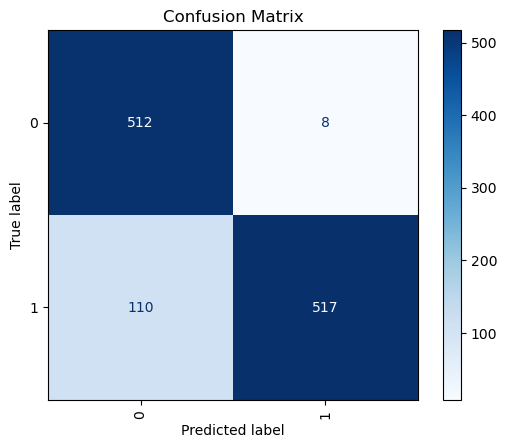

In [104]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_g,
                                        display_labels=best_model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# Calculate Precision
precision = precision_score(y_test, y_pred_rf_g, average='macro')
precision

0.903956515081917

In [108]:
# Calculate Recall
recall = recall_score(y_test, y_pred_rf_g, average='macro')
recall

0.9045883940620782

In [110]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred_rf_g, average='macro')
f1

0.8971209744113641

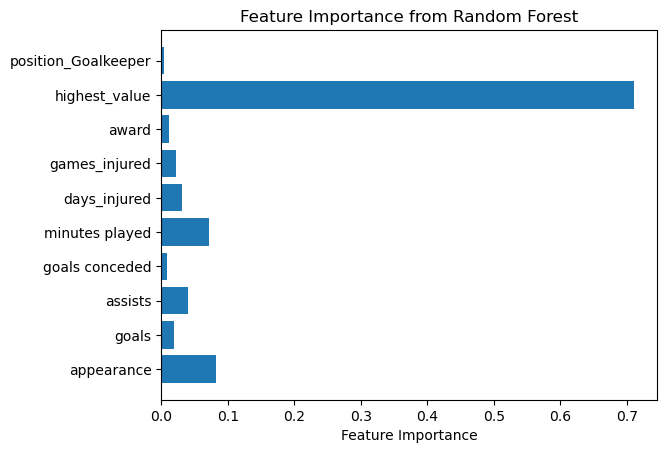

In [112]:
# Feature importance from Random Forest best model
feature_importances = best_model.feature_importances_
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()